In [1]:
## testing printing output from console
import subprocess

cmd = [ 'echo', '"Welcome to my PySpark analysis of the StackOverflow dataset"' ]
output = subprocess.Popen( cmd, stdout=subprocess.PIPE ).communicate()[0]
print(output)

b'"Welcome to my PySpark analysis of the StackOverflow dataset"\n'


# Load Libraries

In [2]:
import gc #garbage collection
import time
import numpy as np
import pandas as pd
from datetime import datetime

# Load PySpark

In [3]:
%run -i '1-load-pyspark.py'

The Spark UI, version 2.4.3, is available at: http://192.168.0.26:4040/ and the defaultParallelism is 4


# Load easyFunctions and Transformers

In [4]:
## easy functions
%run -i 'load_parquet_data.py'
%run -i 'convert_stackov_csv_to_pyarrow_parquet.py'
%run -i 'export_parquet_data.py'
%run -i 'count_total_questions.py'
%run -i 'show_save_results.py'
%run -i 'show_spark_df.py'
%run -i 'show_date_range.py'
%run -i 'trim_betw_dates.py'

## pipeline transformers
%run -i 'nltkWordPunctTokeniser.py'
%run -i 'nltkSenteniser.py'

# Choose Datasets

In [5]:
## these are the forum labels that will appear in graphs/tables etc.
data_array = [
    #'Mar-09',
    #'Apr-09',
    
    'May-09',
    'Jun-09',
    'Jul-09',
    'Aug-09',
    
    #'Sep-09',
    #'Oct-09',
    #'Nov-09',
    #'Dec-09'
]

# Download XML Data

In [6]:
## call download script - EDIT to feed in user data_array
#!bash 0-dataset-download.sh

# Convert to Parquet

In [7]:
%%time
print(datetime.now().time())

## convert stackoverflow .json files to .parquet
#for i in data_array:
#    s = i.lower()
#    convert_stackov_csv_to_pyarrow_parquet(strDirect=f'initial-data/{s}.stackexchange.com/')

09:40:07.460120
CPU times: user 991 µs, sys: 1.06 ms, total: 2.05 ms
Wall time: 1.81 ms


In [8]:
## loop through data_array to convert to other fora to .parquet
#for i in data_array:
#    s = i.lower()
#    !python convert-xml-to-parquet.py "$s"

# Load Initial or Clean Data

In [9]:
%%time
print(datetime.now().time())
datasets = load_parquet_data(dataArray=data_array, kind='clean', printSchema=False) #, gcpath='gs://bucket-brad-project/')

09:40:07.484018
CPU times: user 4.73 ms, sys: 2.71 ms, total: 7.45 ms
Wall time: 5.06 s


In [10]:
## count questions before trimming
count_total_questions(dataArray=data_array, datasetDict=datasets)

May-09: 26026
Jun-09: 28555
Jul-09: 32752
Aug-09: 32998

Total: 120331


# Clean and Trim Data

In [11]:
%%time
print(datetime.now().time())
#%run -i '2-clean-datasets.py'

09:40:16.594227
CPU times: user 396 µs, sys: 97 µs, total: 493 µs
Wall time: 466 µs


In [12]:
## show range of dates for datasets before trimming
show_date_range(dataArray=data_array, datasetDict=datasets)

May-09:
2009-05-01 00:02:42.960000
2009-05-31 23:56:47.303000

Jun-09:
2009-06-01 00:06:57.250000
2009-06-30 23:59:14.543000

Jul-09:
2009-07-01 00:01:35.740000
2009-07-31 23:58:46.123000

Aug-09:
2009-08-01 00:02:10.593000
2009-08-31 23:59:12.223000



In [13]:
## trim data between uniform date range
#datasets = trim_betw_dates(dataArray=data_array, datasetDict=datasets, dates=('2014-06-01', '2017-01-01'))

In [14]:
## show range of dates for datasets after trimming
show_date_range(dataArray=data_array, datasetDict=datasets)

May-09:
2009-05-01 00:02:42.960000
2009-05-31 23:56:47.303000

Jun-09:
2009-06-01 00:06:57.250000
2009-06-30 23:59:14.543000

Jul-09:
2009-07-01 00:01:35.740000
2009-07-31 23:58:46.123000

Aug-09:
2009-08-01 00:02:10.593000
2009-08-31 23:59:12.223000



In [15]:
## count questions after trimming
count_total_questions(dataArray=data_array, datasetDict=datasets)

May-09: 26026
Jun-09: 28555
Jul-09: 32752
Aug-09: 32998

Total: 120331


# Counts and LDA Feature Engineering

In [16]:
%%time
# about 16 min with 10 iterations and params for 29000 questions
# FAILS for large datasets
print(datetime.now().time())
#%run -i '3-feat-engineering.py'

###
# TRY different values of alpha and rho
# TRY different values of K
# TRY 'em' optimizer instead of 'online'

09:29:55.058692
CPU times: user 119 µs, sys: 35 µs, total: 154 µs
Wall time: 150 µs


# Export Clean Data

In [17]:
%%time
# about 12 min
print(datetime.now().time())
#export_parquet_data(dataArray=data_array, datasetDict=datasets)

09:29:55.958472
CPU times: user 643 µs, sys: 362 µs, total: 1 ms
Wall time: 988 µs


# EDA

In [18]:
from pyspark.sql.functions import lit, expr

# find minimum for log plotting
minp = 100
for i in data_array:
    if (min(datasets[i].select('score').rdd.flatMap(lambda x: x).collect()) < minp):
        minp = min(datasets[i].select('score').rdd.flatMap(lambda x: x).collect() )

for i in data_array:
    datasets[i] = datasets[i].withColumn('new_column', lit(minp)).\
    withColumn('total', expr("new_column + score"))

In [19]:
# import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# collect data
plot_data = pd.DataFrame()
for i in data_array:
    temp = datasets[i].select('total').toPandas()
    temp['dataset'] = i
    plot_data = plot_data.append(temp)

# plot
fig, ax = plt.subplots(figsize=(7, 7))
sns.violinplot( x=plot_data['dataset'], y=plot_data['total'] )

# set y-axis to log
#ax.set_yscale('log')

/Users/brad/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Viewcount violin plot

Score violin plot



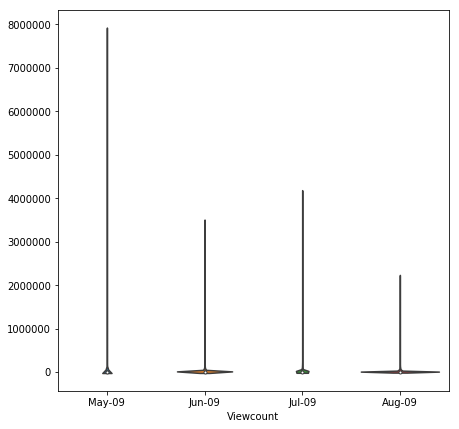

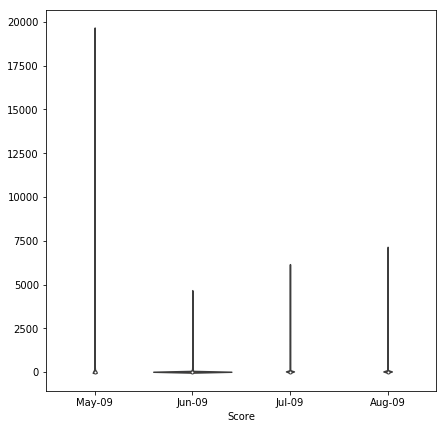

In [20]:
# re-establish empty dictionary of plotting data skeleton
plot_data = {}

## choose variables to describe
desc_array = ['viewcount', 'score']

for k in desc_array:
    print(f'\033[1m{k.title()}\033[0m violin plot\n')
    
    # collect data
    plot_data = pd.DataFrame()
    for i in data_array:
        temp = datasets[i].select(k).toPandas()
        temp['dataset'] = i
        plot_data = plot_data.append(temp)

    # plot
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.violinplot( x=plot_data['dataset'], y=plot_data[k] )

    # axis labels
    ax.set_xlabel(k.title())
    ax.set_ylabel('')

    # set y-axis to log
    #ax.set_yscale('log')

Text(0, 0.5, 'Density')

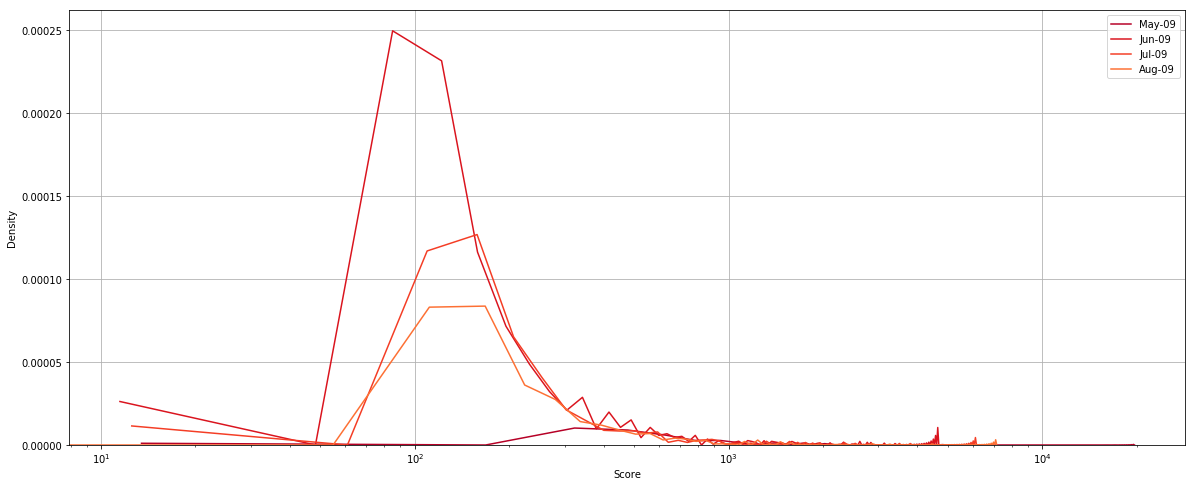

In [27]:
from pyspark.sql.functions import lit, expr

# re-establish empty dictionary of plotting data skeleton
plot_data = {}

# find minimum for log plotting
minp = 100
for i in data_array:
    if (min(datasets[i].select('score').rdd.flatMap(lambda x: x).collect()) < minp):
        minp = abs(min( datasets[i].select('score').rdd.flatMap(lambda x: x).collect() ))

for i in data_array:
    plot_data[i] = datasets[i].withColumn('new_column', lit(minp)).\
    withColumn('total', expr("new_column + score")).\
    select('total').rdd.flatMap(lambda x: x).collect() 

# set colour palette
seq_col_brew = sns.color_palette("YlOrRd_r", 8)
sns.set_palette(seq_col_brew)

# plot
fig, ax = plt.subplots(figsize=(20, 8))
for i in data_array:
    sns.kdeplot(plot_data[i], label=i)

# set grids to true
ax.grid(True)

# set x-axis to log
ax.set_xscale('log')

# axis labels
ax.set_xlabel('Score')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

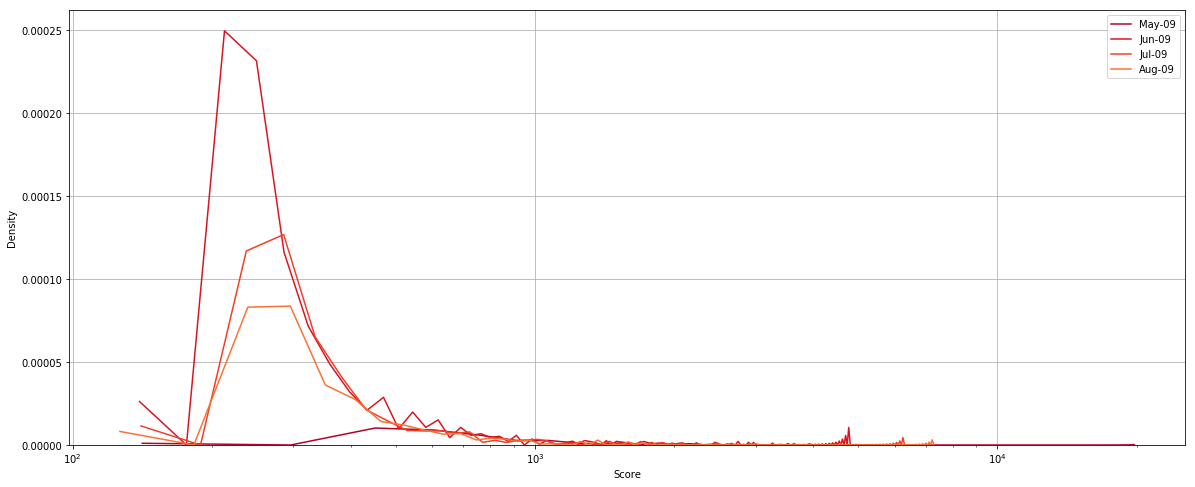

In [28]:
from pyspark.sql.functions import lit, expr

# re-establish empty dictionary of plotting data skeleton
plot_data = {}

# find minimum for log plotting
minp = 100
for i in data_array:
    if (min(datasets[i].select('score').rdd.flatMap(lambda x: x).collect()) < minp):
        minp = abs(min( datasets[i].select('score').rdd.flatMap(lambda x: x).collect() ))

for i in data_array:
    plot_data[i] = datasets[i].withColumn('new_column', lit(150)).\
    withColumn('total', expr("new_column + score")).\
    select('total').rdd.flatMap(lambda x: x).collect() 

# set colour palette
seq_col_brew = sns.color_palette("YlOrRd_r", 8)
sns.set_palette(seq_col_brew)

# plot
fig, ax = plt.subplots(figsize=(20, 8))
for i in data_array:
    sns.kdeplot(plot_data[i], label=i)

# set grids to true
ax.grid(True)

# set x-axis to log
ax.set_xscale('log')

# axis labels
ax.set_xlabel('Score')
ax.set_ylabel('Density')

In [18]:
%%time
print(datetime.now().time())
%run -i '4-final-eda.py'

09:49:10.398005

Correlations between score and viewcount

May-09 & 0.86 \\
Jun-09 & 0.85 \\
Jul-09 & 0.81 \\
Aug-09 & 0.71 \\

Viewcount descriptives

\begin{tabular}{lrrrrr}
\toprule
0 &  count &      mean &    stddev &  min &      max \\
\midrule
May-09 &  26026 &  13817.10 &  81232.90 &   26 &  7906137 \\
Jun-09 &  28555 &  13947.78 &  77665.88 &   26 &  3488812 \\
Jul-09 &  32752 &  11898.35 &  65537.76 &   22 &  4170244 \\
Aug-09 &  32998 &  10516.82 &  48035.64 &   22 &  2223778 \\
\bottomrule
\end{tabular}


Score descriptives

\begin{tabular}{lrrrrr}
\toprule
0 &  count &   mean &  stddev &  min &    max \\
\midrule
May-09 &  26026 &  13.27 &  142.04 &   -7 &  19640 \\
Jun-09 &  28555 &  13.36 &   87.23 &   -9 &   4655 \\
Jul-09 &  32752 &  11.34 &   76.61 &   -8 &   6145 \\
Aug-09 &  32998 &   9.88 &   70.81 &  -22 &   7133 \\
\bottomrule
\end{tabular}

Viewcount violin plot

Score violin plot



/Users/brad/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/brad/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


\begin{tabular}{lrrl}
\toprule
{} &  score &  viewcount &                                                title \\
\midrule
0 &  19640 &    7906137 &  How do I undo the most recent local commits in Git? \\
0 &     -7 &        792 &                       List Element without iteration \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrl}
\toprule
{} &  score &  viewcount &                                                                                     title \\
\midrule
0 &   4655 &    2729671 &                            How do I include a JavaScript file in another JavaScript file? \\
0 &     -9 &       1664 &  How can I use a class from a header file in a source file using extern but not \#include? \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrl}
\toprule
{} &  score &  viewcount &                                                  title \\
\midrule
0 &   6145 &    3792462 &    How do I force "git pull" to overwrite local files? \\
0 &     -8 &        349 &  Why does this C function

# Train/Test Splits

In [24]:
## garbage collector to speed up computation
collected = gc.collect()
print(f'Garbage collector: collected {collected} objects.')

Garbage collector: collected 20566 objects.


In [25]:
%%time
print(datetime.now().time())
#%run -i '6a-rand-train-test-split-50.py'
%run -i '6b-time-train-test-split-50.py'

## check standard deviations of variables
print('\nStandard deviations are:\n')
for i in data_array:
    tr = round( pd.to_numeric(train[i].describe('score').select('score').toPandas().iloc[2][0]), 2 )
    te = round( pd.to_numeric(test[i].describe('score').select('score').toPandas().iloc[2][0]), 2 )
    perc = round( (te/tr - 1)*100, 2 )
    s = i.title() + ' & ' + str(tr) + ' & ' + str(te) + ' & ' + str(perc) + ' \\\\'
    print(s)

09:30:42.450741
May-09: 0.5, from 13013 test and 26026 total
Jun-09: 0.5000175100682893, from 14278 test and 28555 total
Jul-09: 0.5, from 16376 test and 32752 total
Aug-09: 0.5, from 16499 test and 32998 total

Standard deviations are:

May-09 & 71.77 & 187.62 & 161.42 \\
Jun-09 & 88.93 & 85.49 & -3.87 \\
Jul-09 & 87.17 & 64.32 & -26.21 \\
Aug-09 & 62.69 & 78.1 & 24.58 \\
CPU times: user 90.2 ms, sys: 25.2 ms, total: 115 ms
Wall time: 5.78 s


In [ ]:
## garbage collector to speed up computation
collected = gc.collect()
print(f'Garbage collector: collected {collected} objects.')

# Create Results Dictionary

In [ ]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

# Silly Mean Model

In [ ]:
import pyspark.sql.functions as F

## choose target variable
target = 'score'

## create mean dictionaries
y_ravi_tr_means = {}

## calculate the mean of each forum, using ONLY training set
for i in data_array:
    y_ravi_tr_means[i] = train[i].select(target).rdd.flatMap(lambda x: x).mean()

## import rmse evaluator
from pyspark.ml.evaluation import RegressionEvaluator

## create dictionaries for training and testing (baseline) rmse 
base = {}
tr_rmse = {}

## modelling
for i in data_array:

    ## initial variable for timing
    t0 = time.time()
    
    ## train silly mean model by assigning training set mean for training and testing predictions
    train[i] = train[i].withColumn('mean_pred', F.lit(y_ravi_tr_means[i]))
    test[i] = test[i].withColumn('mean_pred', F.lit(y_ravi_tr_means[i]))

    ## evaluate silly mean model, on both training and testing set
    evaluator = RegressionEvaluator(metricName='rmse', labelCol=target, predictionCol='mean_pred')
    tr_rmse[i] = round( evaluator.evaluate(train[i]), 2)
    base[i] = round( evaluator.evaluate(test[i]), 2)

    print(f"The root-mean-square error of \033[94m{i}'s\033[0m\033[92m mean\033[0m model is {base[i]}")

    ## record time taken
    timet = round( time.time() - t0, 2 )
    
    ## store as dictionary inside RESULTS dictionary, initiating dataset name entries first
    RESULTS[i.title()]['0silly_mean.0tr_rmse'] = tr_rmse[i]
    RESULTS[i.title()]['0silly_mean.1rmse'] = base[i]
    RESULTS[i.title()]['0silly_mean.2timet'] = timet
    
## record results
show_save_results(RESULTS)

In [ ]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

# Viewcount Model

In [ ]:
%%time
print(datetime.now().time())

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import CountVectorizer, StandardScaler, VectorAssembler, VectorSlicer

########################
##### CHOOSE FEATS #####
########################

## define features to predict on
target = 'score'
numic_variables = ['viewcount']
datet_variables = ['clean_date']

## numerical columns
numic_assembler = VectorAssembler(inputCols=numic_variables, outputCol='numic_data') # have to put in single col
standardiser = StandardScaler(inputCol='numic_data', outputCol='numic_data_std')    
numic_pipeline = Pipeline(stages=[numic_assembler, standardiser])

'''## date columns
datet_assembler = VectorAssembler(inputCols=datet_variables, outputCol='datet_data')'''

## create processing pipeline
process_assembler = VectorAssembler(inputCols=['numic_data'], #inputCols=['datet_data']
                                    outputCol='features') 
process_pipeline = Pipeline(stages=[numic_pipeline, process_assembler])

########################
##### CHOOSE MODEL #####
########################

## linear regression on just viewcount
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
    
lr = LinearRegression(#maxIter=100, # this doesn't change anything
                      #regParam=0.3, # using regularisation parameter here useless since there is one feature
                      #elasticNetParam=0.8,
                      featuresCol='features',
                      labelCol=target,
                      predictionCol='viewcount_pred')

## make final pipeline
final_pipeline = Pipeline(stages=[process_pipeline, lr])

## import methods for tuning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## set up grid for parameter tuning: 
paramGrid = ParamGridBuilder() \
    .build()

## set up rmse evaluator
evaluator = RegressionEvaluator(metricName='rmse', labelCol=target, predictionCol='viewcount_pred')

## set up cross validation for parameter tuning
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)

## modelling
for i in data_array:
    
    ## initial variable for timing
    t0 = time.time()
    
    ## fit on training set with CV
    cvmodel = crossval.fit(train[i])
    
    ## fitting on train and predicting on train/test
    tr_rmse = round( evaluator.evaluate(cvmodel.transform(train[i])), 2 )
    rmse = round( evaluator.evaluate(cvmodel.transform(test[i])), 2 )
        
    print(f"The root-mean-square error of \033[94m{i}'s\033[0m\033[92m viewcount\033[0m model is {rmse}")

    ## calculate improvement over median baseline
    impr = round( (rmse/base[i] - 1)*-100, 2 )
    
    ## record time taken
    timet = round( time.time() - t0, 2 )

    ## store as dictionary inside RESULTS dictionary
    RESULTS[i.title()]['1viewcount.0tr_rmse'] = tr_rmse
    RESULTS[i.title()]['1viewcount.1rmse'] = rmse
    RESULTS[i.title()]['1viewcount.2imprv'] = impr
    RESULTS[i.title()]['1viewcount.3timet'] = timet
    
## record results
show_save_results(RESULTS)

In [ ]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

In [ ]:
'''
Interesting that there are different improvements of viewcount over mean-only prediciton
'''

In [ ]:
## garbage collector to speed up computation
collected = gc.collect()
print(f'Garbage collector: collected {collected} objects.')

## Count Model

In [ ]:
%%time
print(datetime.now().time())

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import CountVectorizer, StandardScaler, VectorAssembler, VectorSlicer

########################
##### CHOOSE FEATS #####
########################

## define features to predict on
target = 'score'
numic_variables = ['body_word_cnt', 'titl_word_cnt', 'body_char_cnt', 
                   'titl_char_cnt', 'body_sent_cnt', 'titl_sent_cnt']
datet_variables = ['clean_date']

'''## date columns
datet_assembler = VectorAssembler(inputCols=datet_variables, outputCol='datet_data')'''

## NUMERICAL columns
numic_assembler = VectorAssembler(inputCols=numic_variables, outputCol='numic_data') # have to put in single col
standardiser = StandardScaler(inputCol='numic_data', outputCol='numic_data_std')    
numic_pipeline = Pipeline(stages=[numic_assembler, standardiser])

## create PROCESSING pipeline
process_assembler = VectorAssembler(inputCols=['numic_data'], #inputCols=['datet_data']
                                    outputCol='features') 
process_pipeline = Pipeline(stages=[numic_pipeline, process_assembler])

########################
##### CHOOSE MODEL #####
########################

## linear regression model
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
    
lr = LinearRegression(#maxIter=100,
                      #regParam=1,
                      #elasticNetParam=1,
                      featuresCol='features',
                      labelCol=target,
                      predictionCol='counts_pred')

## make final pipeline
final_pipeline = Pipeline(stages=[process_pipeline, lr])

## import methods for tuning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## set up grid for parameter tuning: 
'''NEEDED, BUT IMMENSELY SLOWING DOWN'''
# Ravi et al use L2, aka ridge, aka elasticNetParam=0
# regParam is the value of lambda
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [1e-2, 1.]) \
    .addGrid(lr.regParam, [1e-2, 1.]) \
    .build()

## set up rmse evaluator
evaluator = RegressionEvaluator(metricName='rmse', labelCol=target, predictionCol='counts_pred')

## set up cross validation for parameter tuning
'''DEFINITELY SLOWING DOWN'''
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)
## create models dict
models = {}

## modelling
for i in data_array:
    
    ## initial variable for timing
    t0 = time.time()
    
    ## fit on training set with CV
    cvmodel = crossval.fit(train[i])
    models[i] = cvmodel
    
    ## predict and evaluate
    tr_rmse = round( evaluator.evaluate(cvmodel.transform(train[i])), 2 )
    rmse = round( evaluator.evaluate(cvmodel.transform(test[i])), 2 )
    print(f"The root-mean-square error of \033[94m{i}'s\033[0m\033[92m counts\033[0m model is {rmse}")
    
    ## get params
    # elasticnet
    ela_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[1]
    ela_param = cvmodel.bestModel.stages[-1].extractParamMap()[ela_key]
    # reg'sation
    reg_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[9]
    reg_param = cvmodel.bestModel.stages[-1].extractParamMap()[reg_key]

    ## calculate improvement over median baseline
    impr = round( (rmse/base[i] - 1)*-100, 2 )
    
    ## record time taken
    timet = round( time.time() - t0, 2 )

    ## store as dictionary inside RESULTS dictionary
    RESULTS[i.title()]['2counts.0tr_rmse'] = tr_rmse
    RESULTS[i.title()]['2counts.1rmse'] = rmse
    RESULTS[i.title()]['2counts.2imprv'] = impr
    RESULTS[i.title()]['2counts.3timet'] = timet
    RESULTS[i.title()]['2counts.4elastic'] = ela_param
    RESULTS[i.title()]['2counts.5regular'] = reg_param
    
## record results
show_save_results(RESULTS)

In [ ]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

## Text Model

In [ ]:
%%time
print(datetime.now().time())
# 18min 32s for 2-CV and GRIDSEARCH

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, StandardScaler, VectorAssembler, VectorSlicer

########################
##### CHOOSE FEATS #####
########################

## define features to predict on
target = 'score'
textt_variables = ['title', 'clean_body']
datet_variables = ['clean_date']

'''## date columns
datet_assembler = VectorAssembler(inputCols=datet_variables, outputCol='datet_data')'''

## textual columns
# tokenising text cols with custom transformer
nltk_tokeniser_body = nltkWordPunctTokeniser(
    inputCol='clean_body', outputCol='body_words',  
    stopwords=set(nltk.corpus.stopwords.words('english')))

nltk_tokeniser_title = nltkWordPunctTokeniser(
    inputCol='title', outputCol='titl_words',  
    stopwords=set(nltk.corpus.stopwords.words('english')))

# count occurence of tokens, i.e. create dfm
cnt_vectrizr_body = CountVectorizer(inputCol='body_words', outputCol='body_raw_feats') #!!! minDF???
cnt_vectrizr_title = CountVectorizer(inputCol='titl_words', outputCol='titl_raw_feats')

# create IDF dfm
idf_body = IDF(inputCol="body_raw_feats", outputCol="body_feats")
idf_title = IDF(inputCol="titl_raw_feats", outputCol="titl_feats")

## create processing pipeline
process_assembler = VectorAssembler(inputCols=['body_feats', 'titl_feats'], #inputCols=['datet_data']
                                    outputCol='features') 
process_pipeline = Pipeline(stages=[  #inputCols=['datet_data']
    nltk_tokeniser_body, 
    nltk_tokeniser_title,
    cnt_vectrizr_body,
    cnt_vectrizr_title,
    idf_body,
    idf_title,
    process_assembler
])

########################
##### CHOOSE MODEL #####
########################

## linear regression model
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
    
lr = LinearRegression(#maxIter=100,
                      #regParam=1,
                      #elasticNetParam=1,
                      featuresCol='features',
                      labelCol=target,
                      predictionCol='tokens_pred')

## make final pipeline
final_pipeline = Pipeline(stages=[process_pipeline, lr])

## import methods for tuning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## set up grid for parameter tuning: 
'''NEEDED, BUT IMMENSELY SLOWING DOWN'''
# Ravi et al use L2, aka ridge, aka elasticNetParam=0
# regParam is the value of lambda
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [1e-2, 1.]) \
    .addGrid(lr.regParam, [1e-2, 1.]) \
    .build()

## set up rmse evaluator
evaluator = RegressionEvaluator(metricName='rmse', labelCol=target, predictionCol='tokens_pred')

## set up cross validation for parameter tuning
'''DEFINITELY SLOWING DOWN'''
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)
## create models dict
models = {}

## modelling
for i in data_array:
    
    ## initial variable for timing
    t0 = time.time()
    
    ## fit on training set with CV
    cvmodel = crossval.fit(train[i])
    models[i] = cvmodel
    
    ## predict and evaluate
    tr_rmse = round( evaluator.evaluate(cvmodel.transform(train[i])), 2 )
    rmse = round( evaluator.evaluate(cvmodel.transform(test[i])), 2 )
    print(f"The root-mean-square error of \033[94m{i}'s\033[0m\033[92m tokens\033[0m model is {rmse}")
    
    ## get params
    # elasticnet
    ela_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[1]
    ela_param = cvmodel.bestModel.stages[-1].extractParamMap()[ela_key]
    # reg'sation
    reg_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[9]
    reg_param = cvmodel.bestModel.stages[-1].extractParamMap()[reg_key]

    ## calculate improvement over median baseline
    impr = round( (rmse/base[i] - 1)*-100, 2 )
    
    ## record time taken
    timet = round( time.time() - t0, 2 )

    ## store as dictionary inside RESULTS dictionary
    RESULTS[i.title()]['2tokens.0tr_rmse'] = tr_rmse
    RESULTS[i.title()]['2tokens.1rmse'] = rmse
    RESULTS[i.title()]['2tokens.2imprv'] = impr
    RESULTS[i.title()]['2tokens.3timet'] = timet
    RESULTS[i.title()]['2tokens.4elastic'] = ela_param
    RESULTS[i.title()]['2tokens.5regular'] = reg_param
    
## record results
show_save_results(RESULTS)

In [ ]:
RESULTS = {}
for i in data_array:
    # capitalise keys
    RESULTS[i.title()] = {}

In [ ]:
## check predictions aren't constant
models[data_array[0]].transform(test[data_array[0]]).select('tokens_pred').take(10)

In [ ]:
"""why the heck does everything besides interpersonal have constant predictions - it's not the parameters or the size of the data"""
"""it's the number of questions in the data"""

# LDA Features Model

In [ ]:
%%time
print(datetime.now().time())

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, StandardScaler, VectorAssembler, VectorSlicer

########################
##### CHOOSE FEATS #####
########################

## define features to predict on
target = 'score'
numic_variables = ['btd[0]', 'btd[1]', 'btd[2]', 'btd[3]', 'btd[4]', 
                   'btd[5]', 'btd[6]', 'btd[7]', 'btd[8]', 'btd[9]', 
                   'std[0]', 'std[1]', 'std[2]', 'std[3]', 'std[4]', 
                   'std[5]', 'std[6]', 'std[7]', 'std[8]', 'std[9]',
                   'ttd[0]', 'ttd[1]', 'ttd[2]', 'ttd[3]', 'ttd[4]', 
                   'ttd[5]', 'ttd[6]', 'ttd[7]', 'ttd[8]', 'ttd[9]'] 

datet_variables = ['clean_date']

'''## date columns
datet_assembler = VectorAssembler(inputCols=datet_variables, outputCol='datet_data')'''

## numerical columns
numic_assembler = VectorAssembler(inputCols=numic_variables, outputCol='numic_data') # have to put in single col
standardiser = StandardScaler(inputCol='numic_data', outputCol='numic_data_std')    
numic_pipeline = Pipeline(stages=[numic_assembler, standardiser])

## create processing pipeline
process_assembler = VectorAssembler(inputCols=['numic_data'], #inputCols=['datet_data']
                                    outputCol='features') 
process_pipeline = Pipeline(stages=[numic_pipeline, process_assembler])

########################
##### CHOOSE MODEL #####
########################

## linear regression model
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
    
lr = LinearRegression(#maxIter=100,
                      #regParam=1,
                      #elasticNetParam=1,
                      featuresCol='features',
                      labelCol=target,
                      predictionCol='topics_pred')

## make final pipeline
final_pipeline = Pipeline(stages=[process_pipeline, lr])

## import methods for tuning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## set up grid for parameter tuning: 
'''NEEDED, BUT IMMENSELY SLOWING DOWN'''
# Ravi et al use L2, aka ridge, aka elasticNetParam=0
# regParam is the value of lambda
    
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [1e-2, 1.]) \
    .addGrid(lr.regParam, [1e-2, 1.]) \
    .build()

## set up rmse evaluator
evaluator = RegressionEvaluator(metricName='rmse', labelCol=target, predictionCol='topics_pred')

## set up cross validation for parameter tuning
'''DEFINITELY SLOWING DOWN'''
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)
## create models dict
models = {}

## modelling
for i in data_array:
    
    ## initial variable for timing
    t0 = time.time()
    
    ## fit on training set with CV
    cvmodel = crossval.fit(train[i])
    models[i] = cvmodel
    
    ## predict and evaluate
    tr_rmse = round( evaluator.evaluate(cvmodel.transform(train[i])), 2 )
    rmse = round( evaluator.evaluate(cvmodel.transform(test[i])), 2 )
    print(f"The root-mean-square error of \033[94m{i}'s\033[0m\033[92m topics\033[0m model is {rmse}")
    
    ## get params
    # elasticnet
    ela_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[1]
    ela_param = cvmodel.bestModel.stages[-1].extractParamMap()[ela_key]
    # reg'sation
    reg_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[9]
    reg_param = cvmodel.bestModel.stages[-1].extractParamMap()[reg_key]

    ## calculate improvement over median baseline
    impr = round( (rmse/base[i] - 1)*-100, 2 )
    
    ## record time taken
    timet = round( time.time() - t0, 2 )

    ## store as dictionary inside RESULTS dictionary
    RESULTS[i.title()]['2topics.0tr_rmse'] = tr_rmse
    RESULTS[i.title()]['2topics.1rmse'] = rmse
    RESULTS[i.title()]['2topics.2imprv'] = impr
    RESULTS[i.title()]['2topics.3timet'] = timet
    RESULTS[i.title()]['2topics.4elastic'] = ela_param
    RESULTS[i.title()]['2topics.5regular'] = reg_param
    
## record results
show_save_results(RESULTS)

In [ ]:
RESULTS = {}
for i in data_array:
    # capitalise keysa
    RESULTS[i.title()] = {}

# Final Model

In [ ]:
%%time
print(datetime.now().time())

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, StandardScaler, VectorAssembler, VectorSlicer

########################
##### CHOOSE FEATS #####
########################

## define features to predict on
target = 'score'
numic_variables = ['btd[0]', 'btd[1]', 'btd[2]', 'btd[3]', 'btd[4]', 
                   'btd[5]', 'btd[6]', 'btd[7]', 'btd[8]', 'btd[9]', 
                   'std[0]', 'std[1]', 'std[2]', 'std[3]', 'std[4]', 
                   'std[5]', 'std[6]', 'std[7]', 'std[8]', 'std[9]',
                   'ttd[0]', 'ttd[1]', 'ttd[2]', 'ttd[3]', 'ttd[4]', 
                   'ttd[5]', 'ttd[6]', 'ttd[7]', 'ttd[8]', 'ttd[9]',
                   'body_word_cnt', 'titl_word_cnt', 'body_char_cnt', 
                   'titl_char_cnt', 'body_sent_cnt', 'titl_sent_cnt']
datet_variables = ['clean_date']

### DATE columns
datet_assembler = VectorAssembler(inputCols=datet_variables, outputCol='datet_data')

### NUMERICAL columns
numic_assembler = VectorAssembler(inputCols=numic_variables, outputCol='numic_data') # have to put in single col
standardiser = StandardScaler(inputCol='numic_data', outputCol='numic_data_std')    
numic_pipeline = Pipeline(stages=[numic_assembler, standardiser])


## create PROCESSING pipeline
process_assembler = VectorAssembler(inputCols=['numic_data'], #inputCols=['datet_data']
                                    outputCol='features') 
process_pipeline = Pipeline(stages=[  #inputCols=['datet_data']
    numic_pipeline,
    process_assembler
])

########################
##### CHOOSE MODEL #####
########################

## linear regression model
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
    
lr = LinearRegression(#maxIter=100,
                      #regParam=1,
                      #elasticNetParam=1,
                      featuresCol='features',
                      labelCol=target,
                      predictionCol='finalm_pred')

## make final pipeline
final_pipeline = Pipeline(stages=[process_pipeline, lr])

## import methods for tuning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## set up grid for parameter tuning: 
'''NEEDED, BUT IMMENSELY SLOWING DOWN'''
# Ravi et al use L2, aka ridge, aka elasticNetParam=0
# regParam is the value of lambda
    
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [1e-2, 1.]) \
    .addGrid(lr.regParam, [1e-2, 1.]) \
    .build()

## set up rmse evaluator
evaluator = RegressionEvaluator(metricName='rmse', labelCol=target, predictionCol='finalm_pred')

## set up cross validation for parameter tuning
'''DEFINITELY SLOWING DOWN'''
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)
## create models dict
models = {}

## modelling
for i in data_array:
    
    ## initial variable for timing
    t0 = time.time()
    
    ## fit on training set with CV
    cvmodel = crossval.fit(train[i])
    models[i] = cvmodel
    
    ## predict and evaluate
    tr_rmse = round( evaluator.evaluate(cvmodel.transform(train[i])), 2 )
    rmse = round( evaluator.evaluate(cvmodel.transform(test[i])), 2 )
    print(f"The root-mean-square error of \033[94m{i}'s\033[0m\033[92m final\033[0m model is {rmse}")
    
    ## get params
    # elasticnet
    ela_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[1]
    ela_param = cvmodel.bestModel.stages[-1].extractParamMap()[ela_key]
    # reg'sation
    reg_key = list(cvmodel.bestModel.stages[-1].extractParamMap().keys())[9]
    reg_param = cvmodel.bestModel.stages[-1].extractParamMap()[reg_key]

    ## calculate improvement over median baseline
    impr = round( (rmse/base[i] - 1)*-100, 2 )
    
    ## record time taken
    timet = round( time.time() - t0, 2 )

    ## store as dictionary inside RESULTS dictionary
    RESULTS[i.title()]['3final.0tr_rmse'] = tr_rmse
    RESULTS[i.title()]['3final.1rmse'] = rmse
    RESULTS[i.title()]['3final.2imprv'] = impr
    RESULTS[i.title()]['3final.3timet'] = timet
    RESULTS[i.title()]['3final.4elastic'] = ela_param
    RESULTS[i.title()]['3final.5regular'] = reg_param
    
## record results
show_save_results(RESULTS)

In [ ]:
## check predictions aren't constant
models[data_array[0]].transform(test[data_array[0]]).select('finalm_pred').take(10)

In [ ]:
fin

# Save predictions

In [ ]:
(trained_pipeline
 .transform(datasets['english'])
 .select(
    indep_text_variables + ["prediction"]
 )
 .write
 .parquet("linreg_prediction.parquet")
)

In [ ]:
linreg_predictions = spark.read.parquet("linreg_prediction.parquet")

In [ ]:
linreg_predictions.toPandas().head()

In [ ]:
linreg_predictions.select("prediction").describe().toPandas()

# Save pipelines

In [ ]:
from joblib import dump, load
dump(estimator_pipeline, 'pipeline.joblib') 

reloaded = load("pipeline.joblib")

#Now we can predict directly!

reloaded.predict(X)[:10]

In [ ]:
## save models DOESN'T WORK BECAUSE: 'NLTKWordPunctTokenizer' object has no attribute '_to_java'
for i in data_array:
    param_dict[i].save(f'{i}-pipeline') 

# Convert notebook to python file

In [ ]:
!jupyter nbconvert --to script 0-master-notebook-pipelines.ipynb